<a href="https://colab.research.google.com/github/MatiasCovarrubias/jaxecon/blob/main/apg_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APG algorithm in Jax/Flax.

This notebook trains a neural net to output the optimal policy of a nonlinear Rbc model.



In [ ]:
# BACKEND RELATED: the default backend is CPU (change in Edit -> Notebook settings)
GPU = True # set True if using GPU (only to see GPU)
if GPU:
  !nvidia-smi

# precision
double_precision = True
from jax import config as jax_config, numpy as jnp, lax, random
if double_precision:
  jax_config.update("jax_enable_x64", True)
  precision = jnp.float64
else:
  precision = jnp.float32

# Imports
import matplotlib.pyplot as plt, flax.linen as nn, pandas as pd, jax, flax, optax, os, json
from flax.training.train_state import TrainState  # Useful dataclass to keep train state
from flax.training import checkpoints
from time import time
from typing import Sequence
jax_config.update("jax_debug_nans", True)

! git clone https://github.com/MatiasCovarrubias/jaxecon
import sys
sys.path.insert(0,'/content/jaxecon')

# Import our modular components
from APG.neural_nets.neural_nets import ActorCritic
from APG.environments.RbcMultiSector import RbcMultiSector
from APG.algorithm.epoch_train import get_apg_train_fn
from APG.algorithm.eval import get_eval_fn
from APG.utilities.plot_results import plot_results

print("JAX devices:", jax.devices())
print("JAX version:", jax.__version__)
print("Flax version:", flax.__version__)
print("Optax version:", optax.__version__)



Thu Jul 31 19:33:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   48C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Configure experiment

In [ ]:
def get_config():
    """Get the experiment configuration."""
    # CREATE LEARNING RATE SCHEDULE
    lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,  # Starting learning rate (usually 0 for warmup)
    peak_value=0.01,
    warmup_steps=1000,
    decay_steps=4000,
    end_value=0.0000001
)

    config_apg = {
        "learning_rate": lr_schedule,
        "n_epochs": 500,
        "steps_per_epoch": 10,
        "epis_per_step": 1024*8,
        "periods_per_epis": 64,
        "eval_n_epis": 1024*8,
        "eval_periods_per_epis": 64,
        "gae_lambda": 0.95,
        "max_grad_norm": None,
        "layers_actor": [16, 8],
        "layers_critic": [8, 4],
        "seed": 42,
        "fp64_precision": False,
        "run_name": "apg_RbcMS_modular",
        "date": "modular_implementation",
        # "working_dir": "/content/jaxecon/APG/results/",
    }

    print("Configuration loaded successfully")
    return config_apg


## Create experiment


In [ ]:
def run_experiment(env, config):
    """Runs experiment."""

    n_cores = len(jax.devices())

    # CREATE NN, RNGS, TRAIN_STATE AND EPOCH UPDATE
    nn_policy = ActorCritic(
        actions_dim=env.action_dim,
        hidden_dims_actor=config["layers_actor"],
        hidden_dims_critic=config["layers_critic"],
        activation_final_actor=nn.softmax,
    )

    if config["max_grad_norm"]:
        optim = optax.chain(optax.clip_by_global_norm(config["max_grad_norm"]), optax.adam(config["learning_rate"]))
    else:
        optim = optax.chain(optax.adam(config["learning_rate"]))

    print("Neural Net and Optimizer Created...\n")

    # INITIALIZE ENV AND ALGO STATES
    rng, rng_pol, rng_env, rng_epoch, rng_eval = random.split(random.PRNGKey(config["seed"]), num=5)

    obs, env_state = env.reset(rng_env)
    train_state = TrainState.create(apply_fn=nn_policy.apply, params=nn_policy.init(rng_pol, obs), tx=optim)

    # GET EPOCH TRAIN AND EVAL FUNCTIONS
    epoch_update = jax.jit(get_apg_train_fn(env, config))
    eval_fn = jax.jit(get_eval_fn(env, config))

    # COMPILE CODE
    print("Starting compilation...\n")
    time_start = time()
    epoch_update(train_state, rng_epoch)  # compiles
    eval_fn(train_state, rng_eval)
    time_compilation = time() - time_start
    print("Time Elapsed for Compilation:", time_compilation, "seconds")

    print("Compilation completed. Proceeding to run an epoch and calculate performance statistics...\n")

    # RUN AN EPOCH TO GET TIME STATS
    time_start = time()
    epoch_update(train_state, rng_epoch)
    time_epoch = time() - time_start
    print("Time Elapsed for Epoch:", time_epoch, "seconds")
    print(
        "Steps per second:",
        n_cores * config["steps_per_epoch"] * config["epis_per_step"] * config["periods_per_epis"] / time_epoch,
        "st/s",
    )

    # RUN AN EVAL TO GET TIME STATS
    time_start = time()
    eval_fn(train_state, rng_eval)
    time_eval = time() - time_start
    print("Time Elapsed for Eval:", time_eval, "seconds")

    print("Estimated time for full experiment", (time_epoch + time_eval) * config["n_epochs"] / 60, "minutes\n")

    print("Proceeding to run all epochs...\n")

    # CREATE LISTS TO STORE METRICS
    mean_losses, mean_actor_losses, mean_critic_losses, mean_critic_accs, mean_grads, max_grads = [], [], [], [], [], []

    # RUN ALL THE EPOCHS
    time_start = time()
    for i in range(1, config["n_epochs"] + 1):
        train_state, rng_epoch, epoch_metrics = epoch_update(train_state, rng_epoch)
        eval_metrics = eval_fn(train_state, rng_eval)

        mean_losses.append(float(jnp.mean(epoch_metrics[0][0])))
        mean_actor_losses.append(float(jnp.mean(epoch_metrics[0][1][0])))
        mean_critic_losses.append(float(jnp.mean(epoch_metrics[0][1][1])))
        mean_critic_accs.append(float((1 - jnp.abs(jnp.mean(epoch_metrics[0][1][2]))) * 100))
        mean_grads.append(float(jnp.mean(epoch_metrics[1][0])))
        max_grads.append(float(jnp.mean(jnp.max(epoch_metrics[1][1]))))

        # print(
        #     "Iteration:",
        #     i * config["steps_per_epoch"],
        #     ", Mean_loss:",
        #     jnp.mean(epoch_metrics[0][0]),
        #     ", Mean_actor_loss:",
        #     jnp.mean(epoch_metrics[0][1][0]),
        #     ", Mean_critic_loss:",
        #     jnp.mean(epoch_metrics[0][1][1]),
        #     ", Mean_critic_acc:",
        #     (1 - jnp.abs(jnp.mean(epoch_metrics[0][1][2]))) * 100,
        #     ", Mean_grads:",
        #     jnp.mean(epoch_metrics[1][0]),
        #     ", Max_grads:",
        #     jnp.max(epoch_metrics[1][1]),
        #     ", Learning rate:",
        #     config["learning_rate"](i * config["steps_per_epoch"]),
        #     "\n",
        # )

        print(
            "Evaluation:     ",
            ", Mean_loss:",
            eval_metrics[0],
            ", Mean_actor_loss:",
            eval_metrics[1],
            ", Mean_critic_loss:",
            eval_metrics[2],
            ", Mean_critic_acc:",
            eval_metrics[3],
            ", Mean_grads:",
            eval_metrics[4],
            ", Max_grads:",
            eval_metrics[5],
            "\n",
        )

    # STORE RESULTS
    print("Minimum loss attained in training:", min(mean_losses))

    time_fullexp = (time() - time_start) / 60
    print("Time Elapsed for Full Experiment:", time_fullexp, "minutes")

    results = {
        "min_loss": min(mean_losses),
        "min_actor_loss": min(mean_actor_losses),
        "min_critic_loss": min(mean_critic_losses),
        "last_critic_accs": mean_critic_accs[-1],
        "Time for Full Experiment (m)": time_fullexp,
        "Time for epoch (s)": time_epoch,
        "Time for Compilation (s)": time_compilation,
        "Steps per second": n_cores * config["steps_per_epoch"] * config["periods_per_epis"] / time_epoch,
        "n_cores": n_cores,
        "periods_per_epis": config["periods_per_epis"],
        "epis_per_step": config["epis_per_step"],
        "steps_per_epoch": config["steps_per_epoch"],
        "n_epochs": config["n_epochs"],
        "layers_actor": config["layers_actor"],
        "layers_critic": config["layers_critic"],
        "date": config["date"],
        "seed": config["seed"],
        "Losses_list": mean_losses,
        "Actor_losses_list": mean_actor_losses,
        "Critic_losses_list": mean_critic_losses,
        "Critic_accs_list": mean_critic_accs,
        "Mean_grads_list": mean_grads,
        "Max_grads_list": max_grads,
    }

    # Create results directory if it doesn't exist
    # if not os.path.exists(config["working_dir"]):
    #     os.makedirs(config["working_dir"])
    # if not os.path.exists(config["working_dir"] + config["run_name"]):
    #     os.mkdir(config["working_dir"] + config["run_name"])

    # # Save results
    # with open(config["working_dir"] + config["run_name"] + "/results.json", "w") as write_file:
    #     json.dump(results, write_file)

    # Store checkpoint
    # checkpoints.save_checkpoint(
    #     ckpt_dir=config["working_dir"] + config["run_name"],
    #     target=train_state,
    #     step=config["n_epochs"] * config["steps_per_epoch"],
    # )

    return train_state, results



## Run Experiment

Configuration loaded successfully
Neural Net and Optimizer Created...

Starting compilation...

Time Elapsed for Compilation: 17.020766973495483 seconds
Compilation completed. Proceeding to run an epoch and calculate performance statistics...

Time Elapsed for Epoch: 0.5339381694793701 seconds
Steps per second: 9819264.288807452 st/s
Time Elapsed for Eval: 0.05076265335083008 seconds
Estimated time for full experiment 4.872506856918335 minutes

Proceeding to run all epochs...

Evaluation:      , Mean_loss: 383.1600309112333 , Mean_actor_loss: -21.466340191853018 , Mean_critic_loss: 404.6263711030864 , Mean_critic_acc: -247.44544368039877 , Mean_grads: -81.98454 , Max_grads: 1491.5363 

Evaluation:      , Mean_loss: 330.86983716832367 , Mean_actor_loss: -21.469960946452098 , Mean_critic_loss: 352.3397981147758 , Mean_critic_acc: -175.6465963200908 , Mean_grads: -79.549194 , Max_grads: 1389.3259 

Evaluation:      , Mean_loss: 249.646055760596 , Mean_actor_loss: -21.475742658685306 , Mea

KeyError: 'working_dir'

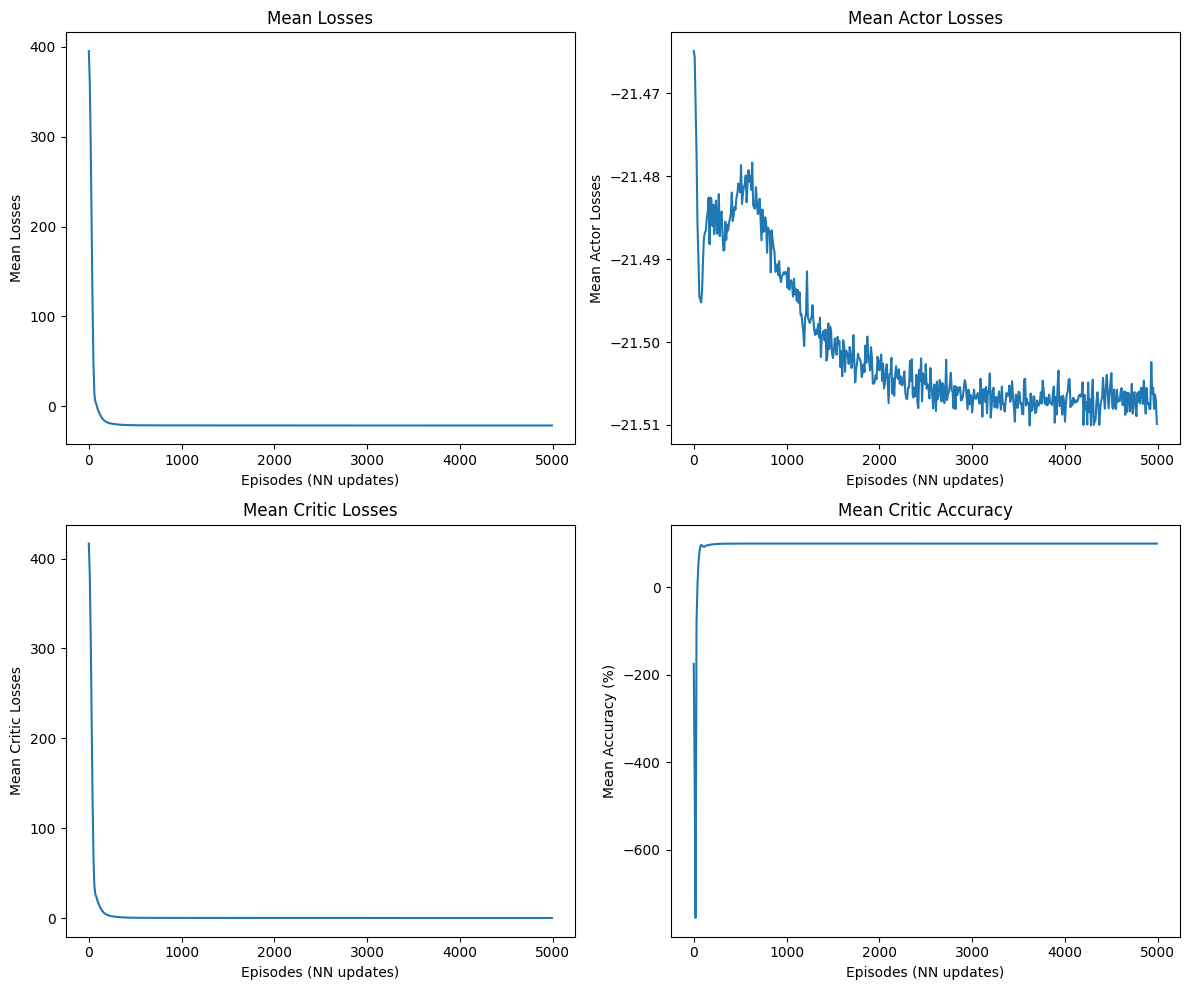

In [ ]:
config_apg = get_config()
final_train_state, results = run_experiment(RbcMultiSector(N=8), config_apg)
plot_results(results, config_apg)
print("\n=== EXPERIMENT SUMMARY ===")
print(f"Minimum loss achieved: {results['min_loss']:.6f}")
print(f"Final critic accuracy: {results['last_critic_accs']:.2f}%")
print(f"Total experiment time: {results['Time for Full Experiment (m)']:.2f} minutes")
print(f"Steps per second: {results['Steps per second']:.0f}")
print(f"Results saved to: {config_apg['working_dir']}{config_apg['run_name']}")